### Importing Libraries

In [1]:
import dataclasses
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score
plt.rcParams['figure.figsize'] = [10,6]

### Attribute Information:

***The dataset consists of 10 000 data points stored as rows with 14 features in columns***

***UID:*** *Unique identifier ranging from 1 to 10000*
    
***Product ID:*** *Consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number*

***Air temperature [K]:*** *Generated using a random walk process later normalized to a standard deviation of 2 K around 300 K*
    
***Process temperature [K]:*** *Generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.*

***Rotational speed [rpm]:*** *Calculated from a power of 2860 W, overlaid with a normally distributed noise*
    
***Torque [Nm]:*** *Torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.*
    
***Tool wear [min]:*** *The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.*

***The machine failure consists of five independent failure modes***

***Tool wear failure (TWF):*** *The tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).*
    
***Heat dissipation failure (HDF):*** *Heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.*
    
***Power failure (PWF):*** *The product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.*
    
***Overstrain failure (OSF):*** *If the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.*
    
***Random failures (RNF):*** *Each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.*

***If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.***



### Loading Data

In [2]:
df=pd.read_csv("ai4i2020.csv")

In [3]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


### Checking for unbalanced Data

In [4]:
df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

<AxesSubplot:>

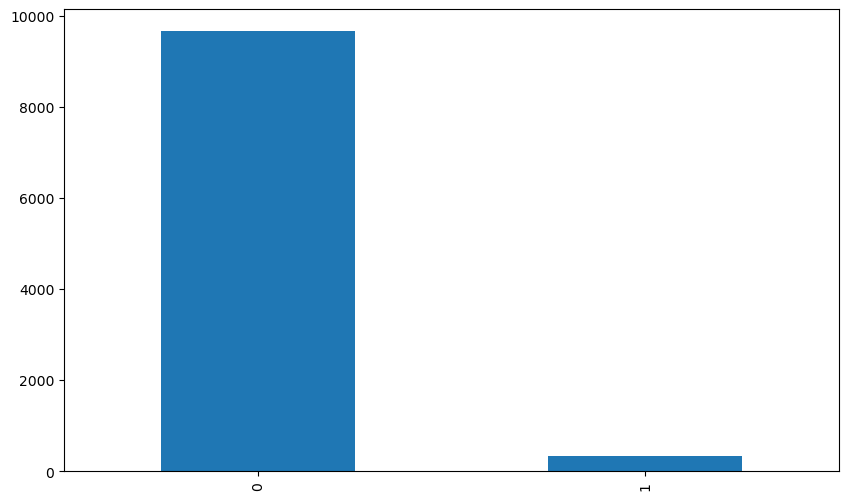

In [5]:
df['Machine failure'].value_counts().plot(kind='bar')

*The data is not balanced*

### Checking for missing values

In [7]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

### Dropping Irrelevant Columns

In [8]:
df.drop(['Product ID'],inplace=True,axis=1)

In [9]:
df.drop(['UDI'],inplace=True,axis=1)

### Utilising the RandomOverSampler Technique to Balance the Data

In [10]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X=df.drop(['Machine failure'],axis=1)
y=df['Machine failure']
X_over, y_over = oversample.fit_resample(X, y)

In [11]:
df_final=pd.concat([X_over, y_over ],axis=1)

In [12]:
df_final.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Machine failure
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [13]:
df_final['Machine failure'].value_counts()

0    9661
1    9661
Name: Machine failure, dtype: int64

<AxesSubplot:>

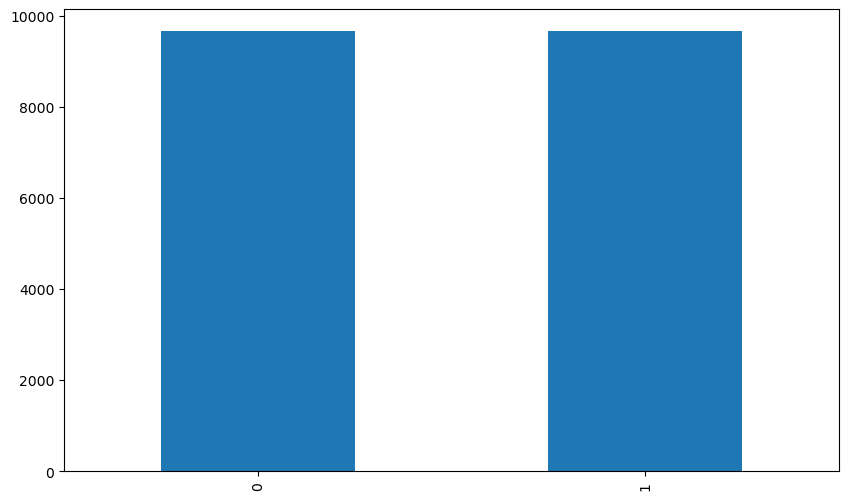

In [14]:
df_final['Machine failure'].value_counts().plot(kind="bar")

*The data is now balanced*

### Data Transformation

In [15]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# Create column transformer 
ct = make_column_transformer(
    (MinMaxScaler(), ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"),["Type"])


)
# Create X & y values
X = df_final.drop("Machine failure", axis=1)
y = df_final["Machine failure"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [16]:
X_train

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
6455,L,300.7,310.1,1565,40.2,81,0,0,0,0,0
11778,L,302.3,311.8,1369,56.2,208,0,0,0,1,0
5352,M,303.4,312.8,1590,36.3,113,0,0,0,0,0
1215,L,296.8,307.9,1709,28.4,118,0,0,0,0,0
18559,L,301.1,310.4,1312,73.6,49,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11284,L,297.3,308.2,1396,52.7,212,0,0,0,1,0
11964,L,301.5,310.9,2760,8.0,15,0,0,1,0,0
5390,H,302.8,312.3,1483,47.2,223,0,0,0,0,0
860,H,296.1,306.9,1541,32.6,33,0,0,0,0,0


In [17]:
X_train_normal

array([[0.58695652, 0.54320988, 0.23108265, ..., 0.        , 1.        ,
        0.        ],
       [0.76086957, 0.75308642, 0.11699651, ..., 0.        , 1.        ,
        0.        ],
       [0.88043478, 0.87654321, 0.24563446, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.81521739, 0.81481481, 0.18335274, ..., 1.        , 0.        ,
        0.        ],
       [0.08695652, 0.14814815, 0.21711292, ..., 1.        , 0.        ,
        0.        ],
       [0.7826087 , 0.64197531, 0.09429569, ..., 0.        , 1.        ,
        0.        ]])

In [18]:
# Shape
X_train_normal.shape, X_train.shape

((15457, 8), (15457, 11))

In [19]:
# View features
X.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0


### Model building

#### Model 1 (Adam)

In [20]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (3 layers)
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(2)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(X_train_normal, y_train, epochs=20, verbose=1) 

Epoch 1/20
484/484 [==============================] - 2s 2ms/step - loss: 0.7127 - accuracy: 0.4071
Epoch 2/20
484/484 [==============================] - 1s 2ms/step - loss: 0.4911 - accuracy: 0.2643
Epoch 3/20
484/484 [==============================] - 1s 2ms/step - loss: 2.3315 - accuracy: 0.4316
Epoch 4/20
484/484 [==============================] - 1s 2ms/step - loss: 2.7125 - accuracy: 0.4056
Epoch 5/20
484/484 [==============================] - 1s 2ms/step - loss: 2.6433 - accuracy: 0.4065
Epoch 6/20
484/484 [==============================] - 1s 2ms/step - loss: 2.9281 - accuracy: 0.4262
Epoch 7/20
484/484 [==============================] - 1s 2ms/step - loss: 4.0459 - accuracy: 0.4999
Epoch 8/20
484/484 [==============================] - 1s 2ms/step - loss: 3.8956 - accuracy: 0.4940
Epoch 9/20
484/484 [==============================] - 1s 2ms/step - loss: 5.1330 - accuracy: 0.4710
Epoch 10/20
484/484 [==============================] - 1s 2ms/step - loss: 3.8614 - accuracy: 0.4765

#### Model 1 (SGD)

In [21]:
tf.random.set_seed(42)

# 1. Create the model (3 layers)
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10), 
  tf.keras.layers.Dense(2)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(), 
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(X_train_normal, y_train, epochs=20, verbose=1) 

Epoch 1/20
484/484 [==============================] - 1s 2ms/step - loss: 5.1104 - accuracy: 0.5004
Epoch 2/20
484/484 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001
Epoch 3/20
484/484 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001
Epoch 4/20
484/484 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001
Epoch 5/20
484/484 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001
Epoch 6/20
484/484 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001
Epoch 7/20
484/484 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001
Epoch 8/20
484/484 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001
Epoch 9/20
484/484 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001
Epoch 10/20
484/484 [==============================] - 1s 2ms/step - loss: 7.6231 - accuracy: 0.5001

*The Accuracy is very low for both optimisers.However the SGD performed a little bit better than the ADAM optimiser.We need to add more layers and perform hyperparameter optimisation*

#### Model 2 (ADAM)

In [36]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_2_A = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(2, activation="sigmoid") 
])

# Compile the model
model_2_A.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(lr=0.01), # ideal learning rate 
                 metrics=["accuracy"])

# Fit the model
history = model_2_A.fit(X_train_normal,
                       y_train,
                       epochs=30,
                       validation_data=(X_test_normal, y_test))

C:\Users\trymo\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
484/484 [==============================] - 3s 4ms/step - loss: 0.3501 - accuracy: 0.8424 - val_loss: 0.2707 - val_accuracy: 0.8924
Epoch 2/30
484/484 [==============================] - 2s 3ms/step - loss: 0.2847 - accuracy: 0.8783 - val_loss: 0.3428 - val_accuracy: 0.8479
Epoch 3/30
484/484 [==============================] - 2s 3ms/step - loss: 0.2712 - accuracy: 0.8859 - val_loss: 0.2862 - val_accuracy: 0.8724
Epoch 4/30
484/484 [==============================] - 2s 4ms/step - loss: 0.2625 - accuracy: 0.8907 - val_loss: 0.2225 - val_accuracy: 0.9107
Epoch 5/30
484/484 [==============================] - 2s 4ms/step - loss: 0.2520 - accuracy: 0.8977 - val_loss: 0.2443 - val_accuracy: 0.9017
Epoch 6/30
484/484 [==============================] - 2s 4ms/step - loss: 0.2454 - accuracy: 0.9030 - val_loss: 0.2184 - val_accuracy: 0.9177
Epoch 7/30
484/484 [==============================] - 2s 4ms/step - loss: 0.2317 - accuracy: 0.9050 - val_loss: 0.2078 - val_accuracy: 0.9107
Epoch 

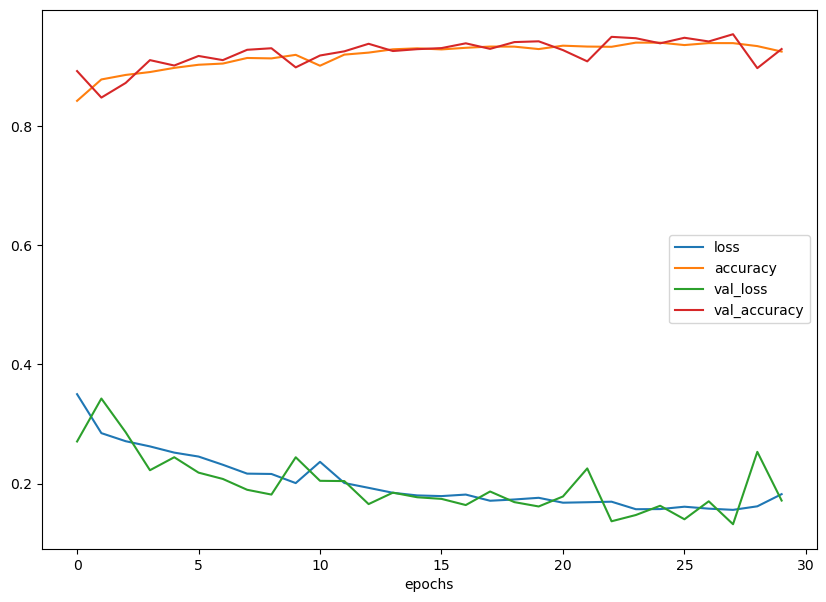

In [37]:
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

#### Model 2 (SGD)

In [38]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_2_S = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(2, activation="sigmoid") 
])

# Compile the model
model_2_S.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.SGD(lr=0.01), # ideal learning rate 
                 metrics=["accuracy"])

# Fit the model
history = model_2_S.fit(X_train_normal,
                       y_train,
                       epochs=30,
                       validation_data=(X_test_normal, y_test))

C:\Users\trymo\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
484/484 [==============================] - 2s 4ms/step - loss: 0.6894 - accuracy: 0.5719 - val_loss: 0.6831 - val_accuracy: 0.5752
Epoch 2/30
484/484 [==============================] - 2s 3ms/step - loss: 0.6730 - accuracy: 0.6690 - val_loss: 0.6656 - val_accuracy: 0.5772
Epoch 3/30
484/484 [==============================] - 2s 3ms/step - loss: 0.6412 - accuracy: 0.6891 - val_loss: 0.6130 - val_accuracy: 0.7314
Epoch 4/30
484/484 [==============================] - 2s 3ms/step - loss: 0.5743 - accuracy: 0.7368 - val_loss: 0.5315 - val_accuracy: 0.7524
Epoch 5/30
484/484 [==============================] - 2s 4ms/step - loss: 0.4673 - accuracy: 0.8111 - val_loss: 0.5196 - val_accuracy: 0.7338
Epoch 6/30
484/484 [==============================] - 2s 4ms/step - loss: 0.3667 - accuracy: 0.8495 - val_loss: 0.3188 - val_accuracy: 0.8717
Epoch 7/30
484/484 [==============================] - 2s 3ms/step - loss: 0.3266 - accuracy: 0.8590 - val_loss: 0.2974 - val_accuracy: 0.8787
Epoch 

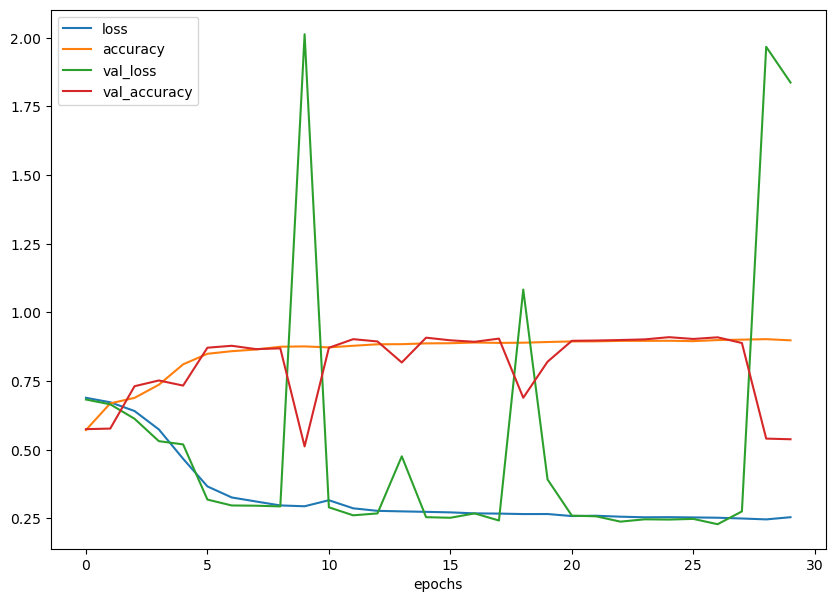

In [39]:
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

*This time the Adam optimiser performed better than the SGD optimiser,hence the ADAM optimiser shall be used for all subsequent trainings*

#### Model 3 (Learning rate Scheduler1)

In [41]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(2, activation="sigmoid") 
])

# Compile the model
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
lr_history = model_3.fit(X_train_normal,
                               y_train,
                               epochs=35, 
                               validation_data=(X_test_normal, y_test),
                               callbacks=[lr_scheduler])

Epoch 1/35
484/484 [==============================] - 3s 5ms/step - loss: 0.5028 - accuracy: 0.7553 - val_loss: 0.3215 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 2/35
484/484 [==============================] - 2s 4ms/step - loss: 0.3025 - accuracy: 0.8654 - val_loss: 0.2655 - val_accuracy: 0.8929 - lr: 0.0011
Epoch 3/35
484/484 [==============================] - 2s 4ms/step - loss: 0.2773 - accuracy: 0.8815 - val_loss: 0.2585 - val_accuracy: 0.8939 - lr: 0.0013
Epoch 4/35
484/484 [==============================] - 2s 3ms/step - loss: 0.2709 - accuracy: 0.8855 - val_loss: 0.2472 - val_accuracy: 0.9050 - lr: 0.0014
Epoch 5/35
484/484 [==============================] - 2s 3ms/step - loss: 0.2638 - accuracy: 0.8887 - val_loss: 0.2411 - val_accuracy: 0.9019 - lr: 0.0016
Epoch 6/35
484/484 [==============================] - 2s 3ms/step - loss: 0.2609 - accuracy: 0.8934 - val_loss: 0.2356 - val_accuracy: 0.9113 - lr: 0.0018
Epoch 7/35
484/484 [==============================] - 2s 4ms/step - lo

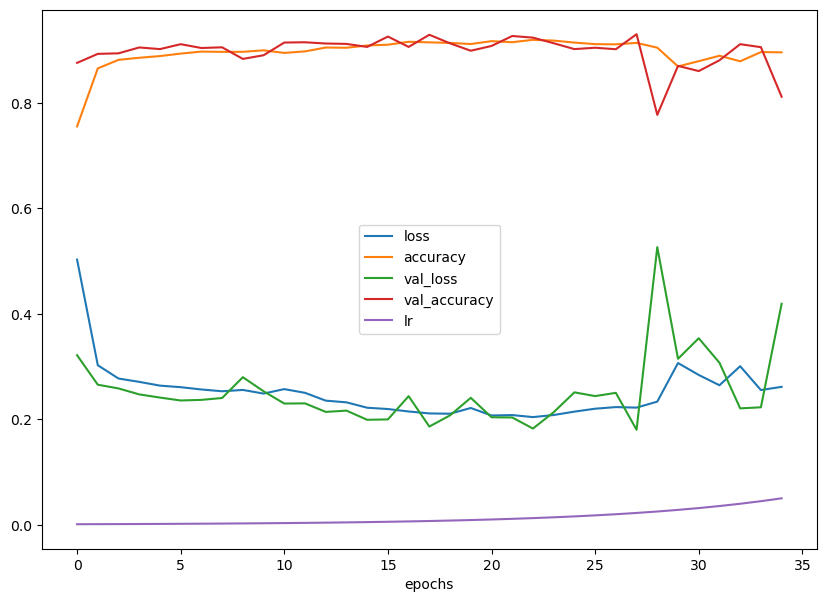

In [42]:
pd.DataFrame(lr_history.history).plot(figsize=(10,7), xlabel="epochs");

#### Finding an Optimal learning rate

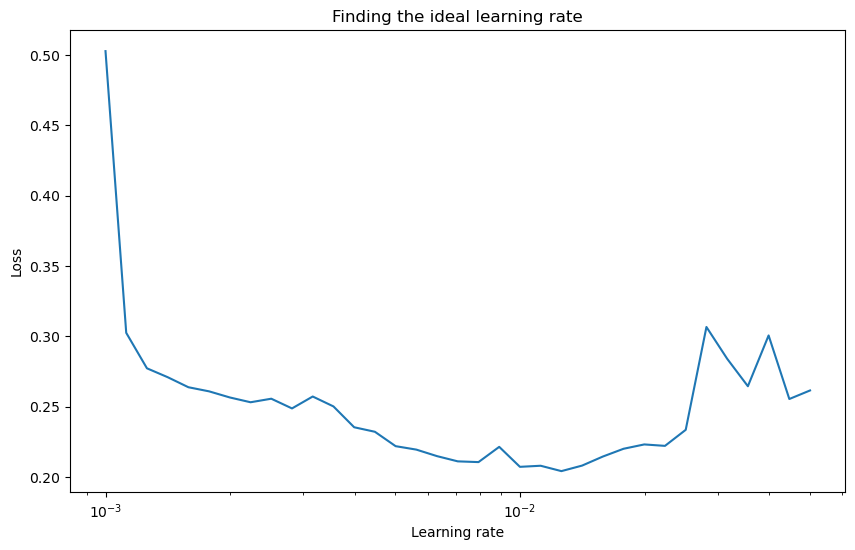

In [45]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt
lrs = 1e-3 * (10**(np.arange(35)/20))
plt.semilogx(lrs, lr_history.history["loss"]) 
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

#### Model 4 (Learning rate Scheduler 2)

In [46]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(2, activation="sigmoid") 
])

# Compile the model
model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
lr_history = model_4.fit(X_train_normal,
                               y_train,
                               epochs=40, 
                               validation_data=(X_test_normal, y_test),
                               callbacks=[lr_scheduler])

Epoch 1/40
484/484 [==============================] - 3s 4ms/step - loss: 0.4739 - accuracy: 0.7816 - val_loss: 0.2960 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 2/40
484/484 [==============================] - 2s 4ms/step - loss: 0.3000 - accuracy: 0.8731 - val_loss: 0.2568 - val_accuracy: 0.8973 - lr: 0.0011
Epoch 3/40
484/484 [==============================] - 2s 4ms/step - loss: 0.2748 - accuracy: 0.8843 - val_loss: 0.2588 - val_accuracy: 0.8903 - lr: 0.0013
Epoch 4/40
484/484 [==============================] - 2s 4ms/step - loss: 0.2675 - accuracy: 0.8892 - val_loss: 0.2445 - val_accuracy: 0.8996 - lr: 0.0014
Epoch 5/40
484/484 [==============================] - 2s 4ms/step - loss: 0.2625 - accuracy: 0.8919 - val_loss: 0.2382 - val_accuracy: 0.9009 - lr: 0.0016
Epoch 6/40
484/484 [==============================] - 2s 4ms/step - loss: 0.2597 - accuracy: 0.8941 - val_loss: 0.2340 - val_accuracy: 0.9058 - lr: 0.0018
Epoch 7/40
484/484 [==============================] - 2s 4ms/step - lo

#### Visualising and checking for suitable Epochs

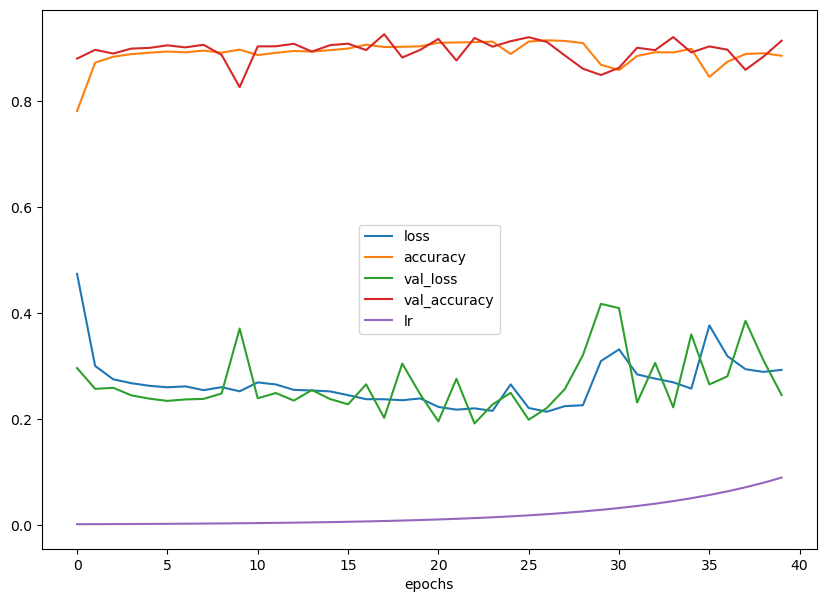

In [47]:
pd.DataFrame(lr_history.history).plot(figsize=(10,7), xlabel="epochs");

#### Finding an Optimal learning rate

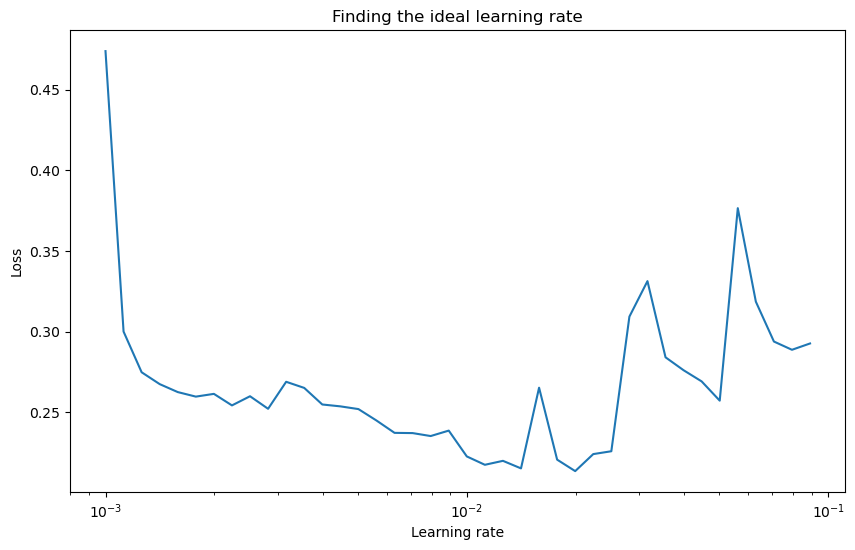

In [48]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt
lrs = 1e-3 * (10**(np.arange(40)/20))
plt.semilogx(lrs, lr_history.history["loss"]) 
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

*We get the minimum loss when the learning rate is a  bit above 0.01.We will start from 0.01*

#### Model 5 (Final)

*** Preferred Architecture***

*Dense(20, activation="relu")*
       
*Dense(10, activation="relu")*
       
*layers.Dense(10, activation="relu")*
              
*Dense(10, activation="relu")*
       
*Dense(2, activation="sigmoid")*

*Learning rate="0.01"*
                      
*Epochs="19"*

*Optimiser="ADAM"*

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(2, activation="sigmoid") 
])

# Compile the model
model_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(lr=0.01), # ideal learning rate 
                 metrics=["accuracy"])

# Fit the model
history = model_5.fit(X_train_normal,
                       y_train,
                       epochs=19,
                       validation_data=(X_test_normal, y_test))

In [51]:
# Evaluating the model
model_5.evaluate(X_test_normal, y_test)

121/121 [==============================] - 0s 3ms/step - loss: 0.1689 - accuracy: 0.9410


[0.16894486546516418, 0.9410090446472168]

In [52]:
model_5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 20)                180       
                                                                 
 dense_43 (Dense)            (None, 10)                210       
                                                                 
 dense_44 (Dense)            (None, 10)                110       
                                                                 
 dense_45 (Dense)            (None, 10)                110       
                                                                 
 dense_46 (Dense)            (None, 2)                 22        
                                                                 
Total params: 632
Trainable params: 632
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Accessing the information in the history variable.
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.350114,0.842402,0.270710,0.892367
1,0.284737,0.878308,0.342786,0.847865
2,0.271197,0.885877,0.286245,0.872445
3,0.262461,0.890729,0.222496,0.910737
4,0.252037,0.897716,0.244280,0.901682
5,0.245430,0.902957,0.218448,0.917723
6,0.231657,0.904962,0.207848,0.910737
7,0.216768,0.914343,0.189666,0.928072
8,0.216209,0.913631,0.181634,0.930660
9,0.200889,0.919583,0.244238,0.898577


#### Visualising model Perfomance

Text(0.5, 1.0, 'Model_5 training curves')

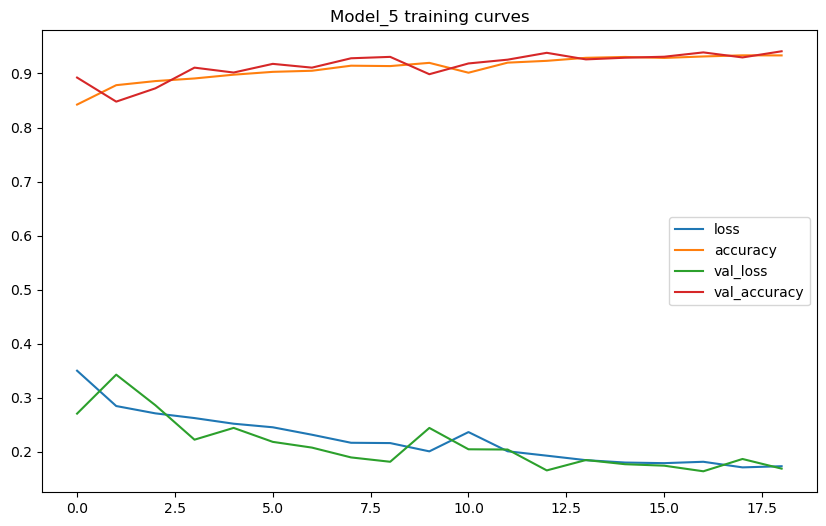

In [54]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_5 training curves")

*The model seems to perform better.Accuracy in general is increasing whereas the loss is decreasing.There is no evidence of overfitting as the model accuracy and the validation accuracy is almost the same*

#### Predictions

In [55]:
# Make predictions with the most recent model
y_probs = model_5.predict(X_test_normal) 

# View the first 5 predictions
(y_probs[:5])

array([[0.94581985, 0.03767815],
       [0.0165177 , 0.9878057 ],
       [0.9752984 , 0.0170157 ],
       [0.9968655 , 0.00218654],
       [0.02959168, 0.98583716]], dtype=float32)

In [56]:
# Convert all of the predictions from probabilities to labels
y_preds = y_probs.argmax(axis=1)

# View the first 10 prediction labels
y_preds[:20]

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0],
      dtype=int64)

#### Confusion Matrix and ROC Curve

##### Confusion Matrix

In [57]:
# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_test, 
                 y_pred=y_preds)

array([[1777,  157],
       [  71, 1860]], dtype=int64)

In [58]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
  n_classes = cm.shape[0] 

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) 
  fig.colorbar(cax)

  #list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), 
         yticks=np.arange(n_classes), 
         xticklabels=labels, 
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

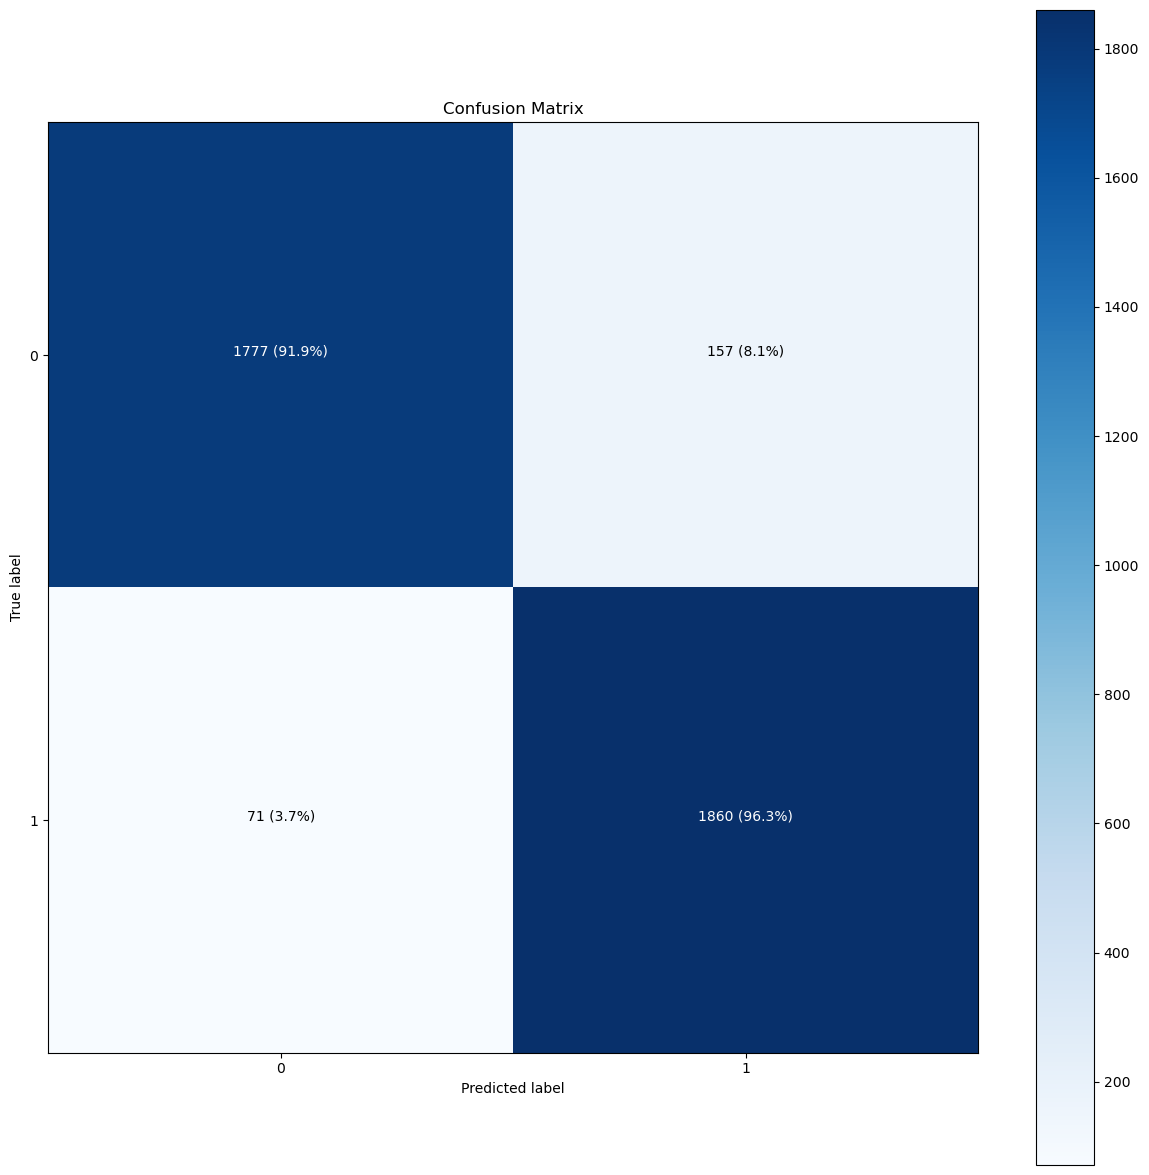

In [59]:
# Make a prettier confusion matrix
make_confusion_matrix(y_true=y_test, 
                      y_pred=y_preds,
                      figsize=(15, 15),
                      text_size=10)

*The model has correctly identified the TP and TN corectly as evidenced by high probabity values*

##### ROC Curve

Model: ROC AUC=0.983


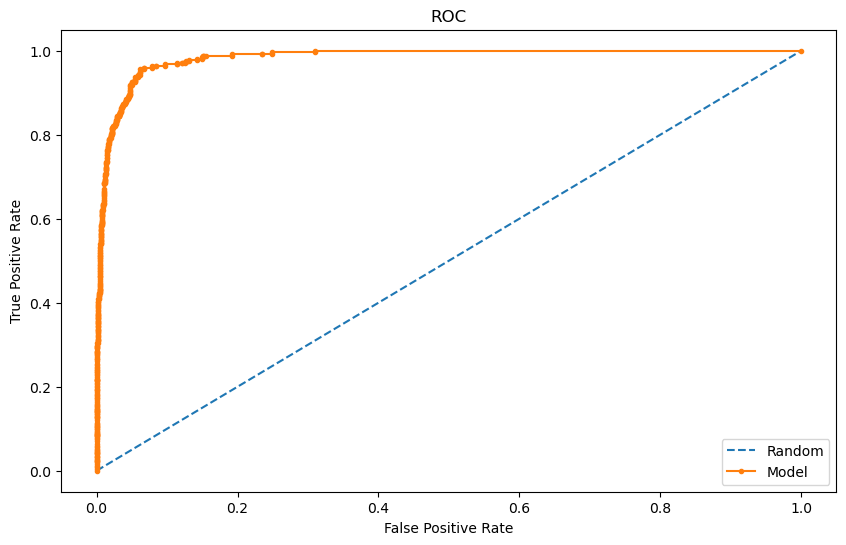

In [60]:
y_pred_proba = model_5.predict(X_test_normal)[::,1]
#Random Probs
random_probs = [0 for _ in range(len(y_test))]
# calculate AUC
model_auc = roc_auc_score(y_test, y_pred_proba)
# summarize score
print('Model: ROC AUC=%.3f' % (model_auc))

# For the Random Model
random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)
# For the actual model
model_fpr, model_tpr, _ = roc_curve(y_test, y_pred_proba)
# Plot the roc curve for the model and the random model line
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
plt.plot(model_fpr, model_tpr, marker='.', label='Model')
# Create labels for the axis
plt.title("ROC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc=4)
# show the plot
plt.show()

*The Area under the curve is very high: closer to 1.The model did its best to correctly classify the outputs*

#### Thank you